In [2]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

PLOTS OF THE GAP THROUGH THE WHOLE SPECTRUM vs MAGNETIC FIELD. Bmin AND Bmax ARE THE VALUES WHERE THE GAP CLOSES IN K=0.

In [62]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=30.
muSC=300.
m=.5
t=1.
alR=0.
B=3.07
delta=.5
phi=np.pi*0

def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=1.
tR=tL

NJ=14
gamma=np.pi*nu0(m)*tL**2

theta=np.arctan(alR/2/a(t)/t)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [63]:
gamma

0.25

In [49]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(mu)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)-kx))))-1j

def gSC1m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

ko=np.linspace(0,6,1000)
kop=[fdetB(opq) for opq in ko]

pp.plot(ko,kop)
pp.axis([0.7,0.8,-10**-23,10**-23])

kop

In [66]:
En=0

def fdetB(B):
    return np.linalg.det(Gtotm1(En,kx,phi,B))/norm

Bmin=25.
Bmax=30.
Barray=[]
x0roots=np.linspace(Bmin,Bmax,np.int((Bmax-Bmin)/.1))
#norm=max(max(mu,t,alR,delta,tL**2)**((2*t+mu)*(NJ+2)),Bmax**(4*(NJ+2)))
#norm=(t**((4.*t+mu)*(NJ+2)))
norm=10.**100
for i in range(len(x0roots)):
    print(i)
    x0=x0roots[i]
    solekx=opt.fsolve(fdetB,np.asarray(x0))
    if abs(fdetB(solekx))>norm/10**5 or solekx<=0:# or solekx>2*np.pi+0.1 :
        solekx=[]
    solekx=np.ndarray.tolist(np.around(solekx,6))
    print(solekx)
    Barray.extend(solekx)
Barray=sorted(list(set(Barray)))

0
[26.043982]
1
[26.043982]
2
[26.043982]
3
[26.043982]
4
[26.043982]
5
[26.043982]
6
[26.043982]
7
[26.043982]
8
[26.043982]
9
[26.043982]
10
[26.043982]
11
[26.173971]
12
[26.173971]
13
[26.384189]
14
[26.384189]
15
[26.665301]
16
[26.665301]
17
[26.665301]
18
[27.38784]
19
[27.004853]
20
[27.004853]
21
[27.004853]
22
[27.38784]
23
[27.38784]
24
[27.38784]
25
[27.38784]
26
[27.797391]
27
[27.797391]
28
[27.797391]
29
[27.797391]
30
[28.21553]
31
[28.21553]
32
[28.21553]
33
[28.21553]
34
[28.623977]
35
[28.623977]
36
[28.623977]
37
[28.623977]
38
[29.004946]
39
[29.004946]
40
[29.004946]
41
[27.797391]
42
[29.341915]
43
[29.341915]
44
[29.004946]
45
[29.620326]
46
[29.620326]
47
[29.828191]
48
[29.828191]
49
[29.956583]


Barray=sorted(list(set(Barray)))

In [1040]:
Barray2=[0.288435, 0.795383, 1.1116, 1.625278, 2.076925, 3.481266, 4.927178, 6.330717, 7.610491, 8.692273, 9.513272, 10.025783]
#Barray=[0.1186,0.5411,0.7734,1.1055,1.5109,1.7271,2.2275,2.9952,3.7386,4.4260,5.0298,5.5262,5.8955,6.1231]
#Barray2.extend([10.0472])

In [67]:
print(len(Barray))
print(Barray)

14
[26.043982, 26.173971, 26.384189, 26.665301, 27.004853, 27.38784, 27.797391, 28.21553, 28.623977, 29.004946, 29.341915, 29.620326, 29.828191, 29.956583]


In [70]:
t*np.pi**2/(4*NJ**2)*(1+4*15)**2

140.5285636854088

In [862]:
Barray2.append(11.51331)
#Barray=[0.0937206766, 1.3330034582, 1.9159320284, 4.1839446374, 6.4621342756, 8.4120038978, 9.7319709969]

In [25]:
Barray=Barray2

In [57]:
Barray[5:6]=[]

In [24]:
Barray2.insert(1,0.42)

In [419]:
theta=np.arctan(alR/2/a(t)/t)
print(theta)

(0.9649052079556503+0j)


ALL transitions shown


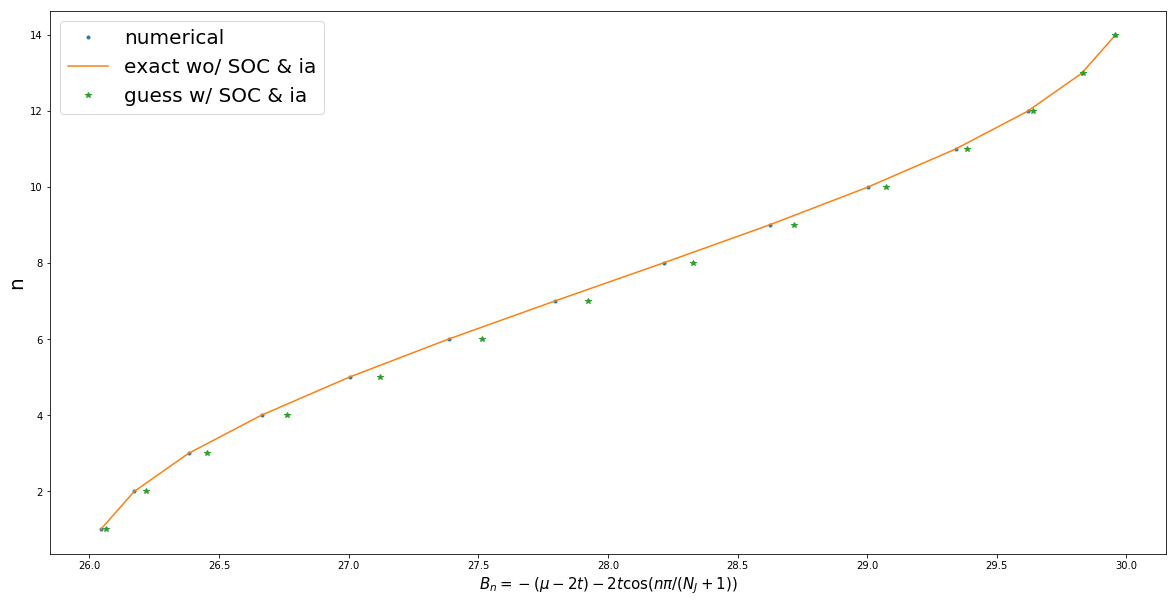

In [68]:
pp.figure(figsize=(20,10))

pp.plot(Barray,range(1,len(Barray)+1),'.',label='numerical')
if len(Barray)==NJ:
    print("ALL transitions shown")
else:
    print("{} MISSING transitions".format(NJ-len(Barray)))

oppp=range(1,len(Barray)+1)

oppD=[abs(mut(kx)+np.sqrt((2*t)**2+(alR/a(t))**2)*np.cos(n*np.pi/(NJ+1)))
    for n in oppp]
oppD=sorted(oppD)

#oppDD=[np.sqrt((mut(kx)+np.sqrt((2*t)**2+(alR/a(t))**2)*np.cos(n*np.pi/(NJ+1)))**2-(alR*kx)**2)
#    for n in oppp]
#oppDD=sorted(oppDD)

opp2=[((np.sqrt((mut(kx)+2*t*np.cos(n*np.pi/(NJ+1)-theta))**2.-(alR*kx)**2.)+\
      alR/a(t)*np.sin(n*np.pi/(NJ+1)-theta))**1+\
      2.*(1+np.cos(phi))*(2*gamma/a(t)/(NJ+1)*np.sin((n-1)*np.pi/(NJ+1)-theta)**2)**1)\
    for n in oppp]
opp2=sorted(opp2)

pp.plot(oppD,oppp,'-',label='exact wo/ SOC & ia')
#pp.plot(oppDD,oppp,'--',label='guess w/ SOC')
pp.plot(opp2,oppp,'*',label='guess w/ SOC & ia')

#################################################################TRIAL AND ERROR FOR FITTING
#opp3=[0.3*np.sqrt(1+np.cos(1.5*(n-3)*np.pi/(NJ+1))**2)-0.17 \
#      for n in oppp]
#pp.plot(opp3,oppp,'-')

#difoppD=[Barray[i]-oppD[i] for i in range(len(Barray))]
#pp.plot(difoppD, oppp,'*')
#difopp2=[Barray[i]-opp2[i] for i in range(len(Barray))]
#pp.plot(difopp2, oppp,'.')
###########################################################################

pp.xlabel('$B_n=-(\mu-2t)-2t \cos(n \pi/(N_J+1))$',fontsize=15)
pp.ylabel('n',fontsize=20)
#pp.axis([0,3,0,7])
pp.legend(fontsize=20)

In [985]:
2*np.arctan(2*(2*np.pi*nu0(m)*tL**2/a(t)/(NJ+1))**2)

(3.1307927585639566+0j)

In [38]:
t*np.pi**2/(4*NJ**2)*(1+4*11)**2

76.47684532731869

In [1027]:
oppD

[0.3962666587138681,
 1.1999999999999993,
 1.4381557247154504,
 3.158110933998418,
 5.2418890660015816,
 7.199999999999999]

In [1029]:
n=1
((np.sqrt((mut(kx)+2*t*np.cos(n*np.pi/(NJ+1)-theta))**2.-(alR*kx)**2.)+\
      alR/a(t)*np.sin(n*np.pi/(NJ+1)-theta))**1+\
      np.arctan(2*(1+np.cos(phi))*(2*gamma/a(t)/(NJ+1))**2)*(np.sin((n-1)*np.pi/(NJ+1)-theta))**1)

(1.4381557247154504+0j)

alR/a(t)*np.sin(np.sign(n*np.pi/(NJ+1)-theta)*np.sqrt((n*np.pi/(NJ+1)-theta)*(n*np.pi/(NJ+1)-theta+0*alR*kx/210.))))**2+\

ALL transitions shown


Text(0,0.5,'n')

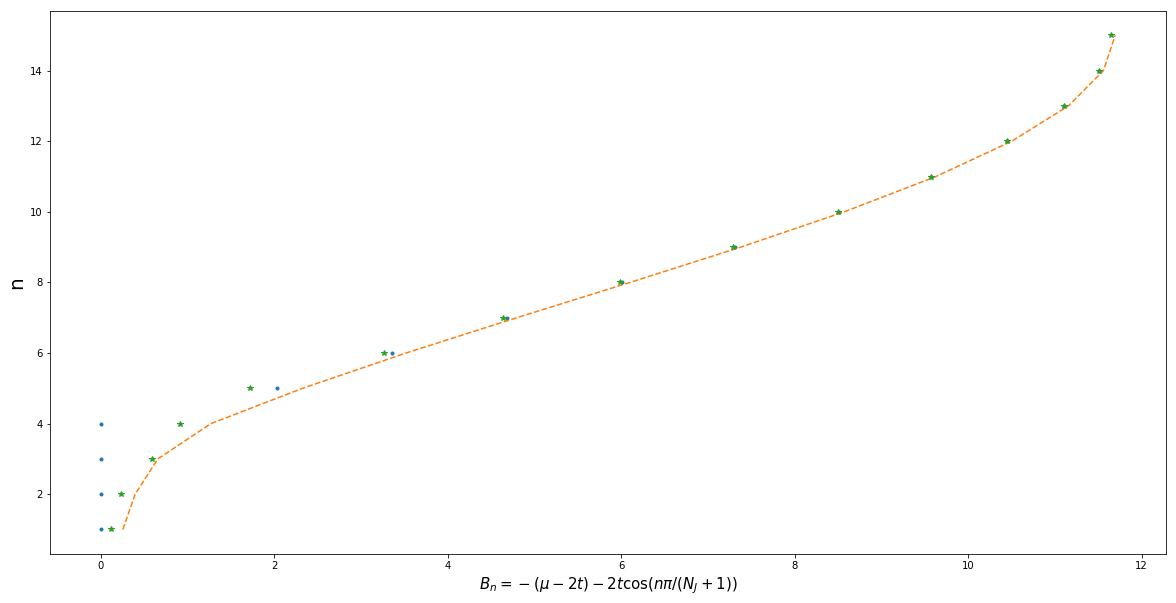

In [605]:
pp.figure(figsize=(20,10))

pp.plot(Barray,range(1,len(Barray)+1),'.')
if len(Barray)==NJ:
    print("ALL transitions shown")
else:
    print("{} MISSING transitions".format(NJ-len(Barray)))

oppp=range(1,NJ+2)
oppD=[abs(-np.sqrt((2*t)**2+(alR/a(t))**2)*np.cos(n*np.pi/(NJ+1)+0*theta)-mut(kx))
    for n in oppp]
oppD=sorted(oppD)

opp2=[np.sqrt((np.sqrt((mut(kx)+2*t*np.cos(n*np.pi/(NJ+1)-theta))**2-(alR*kx)**2)+\
      alR/a(t)*np.sin(n*np.pi/(NJ+1)-theta))**2+\
      2*(1+np.cos(phi))*(2*gamma/a(t)/(NJ+1)*np.sin(n*np.pi/(NJ+1)-theta)**2)**2)\
    for n in oppp]
opp2=sorted(opp2)

#opp3=[np.sqrt(((np.pi*n/a(t)/(NJ+1))**2/2/m-mut(kx))**2+\
#              2*(1+np.cos(phi))*(2*gamma/a(t)/(NJ+1)*(n*np.pi/(NJ+1))**2)**2)\
#     for n in oppp]

pp.plot(oppD,oppp,'--')
pp.plot(opp2,oppp,'*')
#pp.plot(opp3,oppp)

pp.xlabel('$B_n=-(\mu-2t)-2t \cos(n \pi/(N_J+1))$',fontsize=15)
pp.ylabel('n',fontsize=20)
#pp.axis([-1,12,0,15])

In [744]:
oppDD[-1]

(19.465172646470847-0j)

In [296]:
 np.sqrt((1+np.cos(phi))*2)*(2*gamma/a(t)/(NJ+1)*np.sin(n*np.pi/(NJ+1)-theta)**2)

(0.352949191202438+0j)

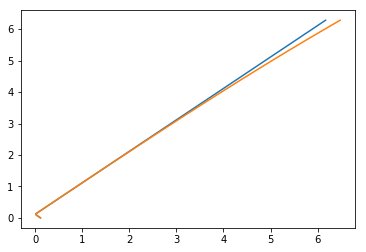

In [125]:
n=1
oppp=np.ndarray.tolist(np.linspace(0,2*np.pi,201))
opp=[np.sqrt((-2*t*np.cos(n*np.pi/(NJ+1))-(mu-2*t))**2+(1+np.cos(phi))*2*(2*gamma/a(t)/(NJ+1)*np.sin(n*np.pi/(NJ+1))**2)**2)\
    for mu in oppp]
opp2=[2*t*np.arccos(1-prev**2/(8*t**2)) for prev in opp]
pp.plot(opp,oppp,opp2,oppp)

In [76]:
2*gamma/a(t)/(NJ+1)*np.sin(n*np.pi/(NJ+1))**2

(0.06682647871860584+0j)

In [90]:
np.pi**2/(2*m*a(t)**2*(NJ+1)**2)

(0.11565942657526589+0j)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


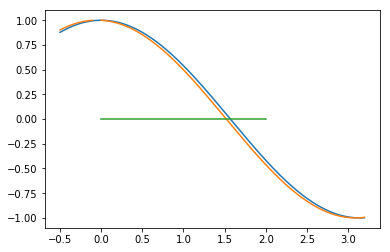

In [791]:
pp.plot(np.linspace(-.5,3.2,1000),[np.cos(b) for b in np.linspace(-.5,3.2,1000)])
pp.plot(np.linspace(-.5,3.2,1000),[np.cos(np.sqrt(b*(b+0.1))) for b in np.linspace(-.5,3.2,1000)])
pp.plot(np.zeros(3))
#pp.axis([-.1,.1,0,0.001])

mu=1.8
t=3
bhj=[i/1000. for i in range(20000)]
btg=[np.arctan(0.5*np.sqrt(B/mu)*np.tan(NJ*np.sqrt(B/t))) for B in bhj]
pp.plot(bhj,btg)
pp.axis([0,20,-1.6,1.6])

In [30]:
Barray=sorted(list(set(Barray)))

In [30]:
(np.pi+phi)/2/np.pi

1.3749999999999998

In [53]:
np.pi/2*(g-1)+mu

1.5957964775166635

In [66]:
4.5*0.185/0.815

1.021472392638037

Compute the gap at the center of the topological phase

In [46]:
Blist=[2.1]#[0.5+i/20. for i in range(21)]#(np.asarray(Barray[0:-2])+np.asarray(Barray[1:-1]))/2
NM=len(Blist)
print(Blist)

Etest=0
LE=101  #E decimation
listEn=np.ndarray.tolist(np.linspace(0,delta/3.,LE))

kmin=-np.pi
kmax=0.1
x0roots=np.linspace(kmin,kmax,np.int((kmax-kmin)/.3))

gaparray=np.zeros(NM)
for tp in range(NM):
    #print("Topological phase nr.",tp+1)
    B=Blist[tp]
    print('B={}'.format(B))
    for En in listEn:
        def fdetkx(kxx):
            return np.linalg.det(Gtotm1(En,kxx,phi,B))/(mu**(8*(NJ+2)))
        for go in range(len(x0roots)):
            solveEKX=opt.fsolve(fdetkx,[x0roots[go]])
            if abs(fdetkx(solveEKX))<10**-6:# and abs(solveEKX)<=kF:
                print("found")
                Etest=1
                break
        if Etest==1:
            break
    print('gap={}'.format(En))
    gaparray[tp]=En
    Etest=0
            

[2.1]
B=2.1
found
gap=0.0733333333333


gapA3=gaparray
Blist3=Blist

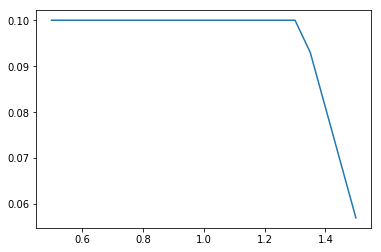

In [44]:
pp.plot(Blist3,gapA3)

gapA2=gaparray
Blist2=Blist

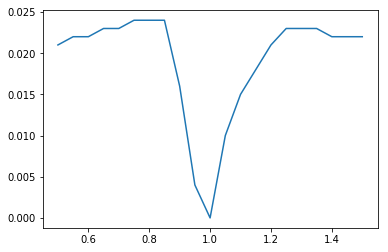

In [23]:
pp.plot(Blist2,gapA2)

gapA1=gaparray
Blist1=Blist

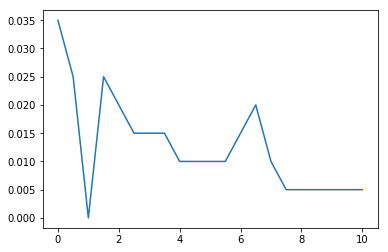

In [15]:
pp.plot(Blist1,gapA1)

In [ ]:
En=0
kxarray=np.linspace(-2.157,-2.155,1000)
detarray=np.asarray([fdetkx(kxarray[i]) for i in range(len(kxarray))])

In [ ]:
pp.plot(kxarray,detarray,'*')
pp.axis([-2.156,-2.1557,-10**2,10*10**2])

In [ ]:
for p in range(len(EJdisp)):
    pp.plot(kxarray,EJdisp[p],'.')

print("{} :".format(solveEKX))
            if abs(fdetkx(solveEKX))<10**-6:
                if abs(solveEKX)<=kF:
                    print("true zero")
                    Emin=En
                else:
                    print("larger than kF")
            else:
                print('false zero')

Text(0.5,1,'Gap size at constant $\\phi$')

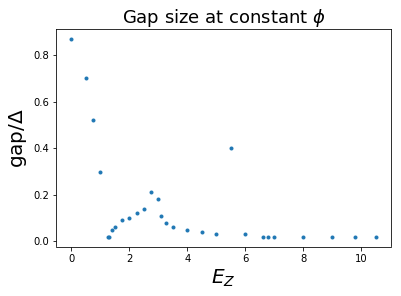

In [567]:
pp.plot(Blist,pytr,'.')
pp.xlabel('$E_Z$',fontsize=20)
pp.ylabel('gap/$\Delta$',fontsize=20)
pp.title('Gap size at constant $\phi$',fontsize=18)